# Entangled Learning: Teacher-Student with PCA

This notebook contains a small prototype demonstrating how the concept of **entangled learning** works in a **teacher-student** architecture.

- **Teacher (MLP_Large):** Trained on the original data
- **Student (MLP_Small):** Works with data simplified by PCA
- **Goal:** The student tries to mimic both the labels and the teacher's outputs

## Data Preparation








In [1]:

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

X, y = make_classification(n_samples=3000, n_features=20, n_informative=15, random_state=42)
X = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=10).fit_transform(X)

X_train, X_test, y_train, y_test, X_pca_train, X_pca_test = train_test_split(X, y, X_pca, test_size=0.2, random_state=42)


## Model Definitions

In [2]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def make_mlp(input_shape, units_list):
    model = Sequential()
    for i, u in enumerate(units_list):
        if i == 0:
            model.add(Dense(u, activation='relu', input_shape=(input_shape,)))
        else:
            model.add(Dense(u, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

mlp_large = make_mlp(X.shape[1], [64, 32])
mlp_small = make_mlp(X_pca.shape[1], [32])


c:\Users\TR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Entangled Training

In [3]:

import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryCrossentropy

optimizer_large = tf.keras.optimizers.Adam()
optimizer_small = tf.keras.optimizers.Adam()
bce = BinaryCrossentropy()

epochs = 10
batch_size = 32
history = {"loss_large": [], "loss_small": [], "kl_large": [], "kl_small": [], "lambda": []}

for epoch in range(epochs):
    λ = 0.05 * np.log1p(epoch) / np.log1p(epochs - 1)  # logaritmik artış
    history["lambda"].append(λ)

    idxs = np.random.permutation(len(X_train))
    X_t, X_p, y_t = X_train[idxs], X_pca_train[idxs], y_train[idxs]
    loss_l_all, loss_s_all, kl_l_all, kl_s_all = [], [], [], []

    for i in range(0, len(X_t), batch_size):
        xb, xpb, yb = X_t[i:i+batch_size], X_p[i:i+batch_size], y_t[i:i+batch_size]

        with tf.GradientTape(persistent=True) as tape:
            yl = mlp_large(xb, training=True)
            ys = mlp_small(xpb, training=True)
            yl_np, ys_np = yl.numpy().flatten(), ys.numpy().flatten()

            ce_l = bce(yb, yl)
            ce_s = bce(yb, ys)
            kl_l = tf.reduce_mean(yl_np * tf.math.log(tf.clip_by_value(yl_np / ys_np, 1e-7, 1e7)))
            kl_s = tf.reduce_mean(ys_np * tf.math.log(tf.clip_by_value(ys_np / yl_np, 1e-7, 1e7)))
            loss_l = ce_l + λ * kl_l
            loss_s = ce_s + λ * kl_s

        grads_l = tape.gradient(loss_l, mlp_large.trainable_weights)
        grads_s = tape.gradient(loss_s, mlp_small.trainable_weights)
        optimizer_large.apply_gradients(zip(grads_l, mlp_large.trainable_weights))
        optimizer_small.apply_gradients(zip(grads_s, mlp_small.trainable_weights))

        loss_l_all.append(loss_l.numpy())
        loss_s_all.append(loss_s.numpy())
        kl_l_all.append(kl_l.numpy())
        kl_s_all.append(kl_s.numpy())

    history["loss_large"].append(np.mean(loss_l_all))
    history["loss_small"].append(np.mean(loss_s_all))
    history["kl_large"].append(np.mean(kl_l_all))
    history["kl_small"].append(np.mean(kl_s_all))


## Visualization of Results

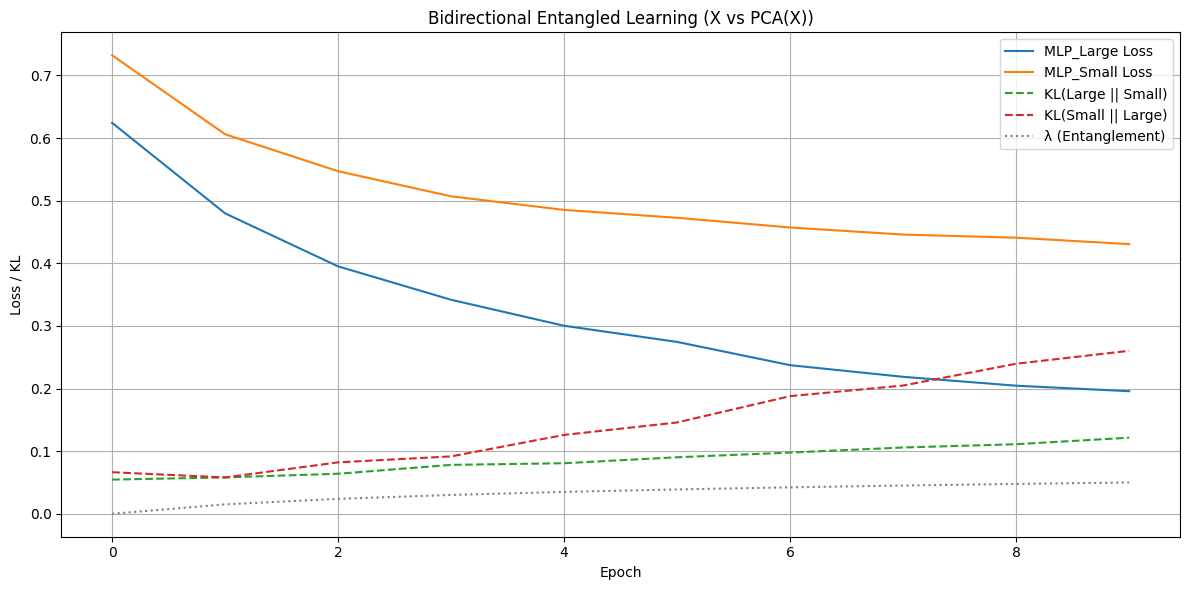

In [4]:

plt.figure(figsize=(12, 6))
plt.plot(history["loss_large"], label="MLP_Large Loss")
plt.plot(history["loss_small"], label="MLP_Small Loss")
plt.plot(history["kl_large"], '--', label="KL(Large || Small)")
plt.plot(history["kl_small"], '--', label="KL(Small || Large)")
plt.plot(history["lambda"], label="λ (Entanglement)", color='gray', linestyle=':')
plt.title("Bidirectional Entangled Learning (X vs PCA(X))")
plt.xlabel("Epoch")
plt.ylabel("Loss / KL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Final Epoch Summary
Entangled Learning: Teacher-Student with PCA


In [6]:

print(f"Last Epoch λ (Entanglement): {history['lambda'][-1]:.4f}")
print(f"MLP_Large Final Loss: {history['loss_large'][-1]:.4f}")
print(f"MLP_Small Final Loss: {history['loss_small'][-1]:.4f}")
print(f"KL(Large || Small) Final: {history['kl_large'][-1]:.4f}")
print(f"KL(Small || Large) Final: {history['kl_small'][-1]:.4f}")


Last Epoch λ (Entanglement): 0.0500
MLP_Large Final Loss: 0.1957
MLP_Small Final Loss: 0.4306
KL(Large || Small) Final: 0.1216
KL(Small || Large) Final: 0.2603
